# 5.0 Batted Ball Profile
Analyzing player batted ball profiles and how they change over time

## Libraries

In [92]:
import os
import re

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## Data

In [4]:
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [5]:
params = {
    'game_type': 'R'
}

In [6]:
SQL = \
"""
SELECT
  t_bb.game_year AS game_year,
  t_players.mlb_id AS mlb_id,
  t_players.mlb_name AS mlb_name,
  t_players.fg_id AS fangraphs_id,
  t_bb.bb_events AS bb_events,
  t_bb.home_runs AS home_runs,
  ROUND(t_bb.home_runs / t_bb.bb_events, 3) AS hr_rate,
  (CASE WHEN t_bb.fly_events > 0 OR t_bb.line_events > 0
      THEN ROUND(t_bb.home_runs / (t_bb.fly_events + t_bb.line_events), 3)
    ELSE 0 END) AS hr_air_rate,
  (CASE WHEN t_bb.fly_events > 0 THEN ROUND(t_bb.fly_home_runs / t_bb.fly_events, 3)
    ELSE 0 END) AS fly_hr_rate,
  (CASE WHEN t_bb.line_events > 0 THEN ROUND(t_bb.line_home_runs / t_bb.line_events, 3)
    ELSE 0 END) AS line_hr_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_oppo_rate,
  t_bb.fly_events AS fly_events,
  t_bb.line_events AS line_events,
  t_bb.ground_events AS ground_events,
  t_bb.pop_events AS pop_events,
  t_bb.fly_pull_events AS fly_pull_events,
  t_bb.fly_center_events AS fly_center_events,
  t_bb.fly_oppo_events AS fly_oppo_events,
  t_bb.line_pull_events AS line_pull_events,
  t_bb.line_center_events AS line_center_events,
  t_bb.line_oppo_events AS line_oppo_events,
  t_bb.ground_pull_events AS ground_pull_events,
  t_bb.ground_center_events AS ground_center_events,
  t_bb.ground_oppo_events AS ground_oppo_events,
  t_bb.pop_pull_events AS pop_pull_events,
  t_bb.pop_center_events AS pop_center_events,
  t_bb.pop_oppo_events AS pop_oppo_events,
  t_bb.fly_max_exit_velo AS fly_max_exit_velo,
  t_bb.fly_p75_exit_velo AS fly_p75_exit_velo,
  t_bb.fly_p90_exit_velo AS fly_p90_exit_velo,
  t_bb.fly_p95_exit_velo AS fly_p95_exit_velo,
  t_bb.fly_pull_max_exit_velo AS fly_pull_max_exit_velo,
  t_bb.fly_pull_p75_exit_velo AS fly_pull_p75_exit_velo,
  t_bb.fly_pull_p90_exit_velo AS fly_pull_p90_exit_velo,
  t_bb.fly_pull_p95_exit_velo AS fly_pull_p95_exit_velo,
  t_bb.fly_center_max_exit_velo AS fly_center_max_exit_velo,
  t_bb.fly_center_p75_exit_velo AS fly_center_p75_exit_velo,
  t_bb.fly_center_p90_exit_velo AS fly_center_p90_exit_velo,
  t_bb.fly_center_p95_exit_velo AS fly_center_p95_exit_velo,
  t_bb.fly_oppo_max_exit_velo AS fly_oppo_max_exit_velo,
  t_bb.fly_oppo_p75_exit_velo AS fly_oppo_p75_exit_velo,
  t_bb.fly_oppo_p90_exit_velo AS fly_oppo_p90_exit_velo,
  t_bb.fly_oppo_p95_exit_velo AS fly_oppo_p95_exit_velo,
  t_bb.line_max_exit_velo AS line_max_exit_velo,
  t_bb.line_p75_exit_velo AS line_p75_exit_velo,
  t_bb.line_p90_exit_velo AS line_p90_exit_velo,
  t_bb.line_p95_exit_velo AS line_p95_exit_velo,
  t_bb.line_pull_max_exit_velo AS line_pull_max_exit_velo,
  t_bb.line_pull_p75_exit_velo AS line_pull_p75_exit_velo,
  t_bb.line_pull_p90_exit_velo AS line_pull_p90_exit_velo,
  t_bb.line_pull_p95_exit_velo AS line_pull_p95_exit_velo,
  t_bb.line_center_max_exit_velo AS line_center_max_exit_velo,
  t_bb.line_center_p75_exit_velo AS line_center_p75_exit_velo,
  t_bb.line_center_p90_exit_velo AS line_center_p90_exit_velo,
  t_bb.line_center_p95_exit_velo AS line_center_p95_exit_velo,
  t_bb.line_oppo_max_exit_velo AS line_oppo_max_exit_velo,
  t_bb.line_oppo_p75_exit_velo AS line_oppo_p75_exit_velo,
  t_bb.line_oppo_p90_exit_velo AS line_oppo_p90_exit_velo,
  t_bb.line_oppo_p95_exit_velo AS line_oppo_p95_exit_velo,
  t_bb.ground_max_exit_velo AS ground_max_exit_velo,
  t_bb.ground_p75_exit_velo AS ground_p75_exit_velo,
  t_bb.ground_p90_exit_velo AS ground_p90_exit_velo,
  t_bb.ground_p95_exit_velo AS ground_p95_exit_velo,
  t_bb.ground_pull_max_exit_velo AS ground_pull_max_exit_velo,
  t_bb.ground_pull_p75_exit_velo AS ground_pull_p75_exit_velo,
  t_bb.ground_pull_p90_exit_velo AS ground_pull_p90_exit_velo,
  t_bb.ground_pull_p95_exit_velo AS ground_pull_p95_exit_velo,
  t_bb.ground_center_max_exit_velo AS ground_center_max_exit_velo,
  t_bb.ground_center_p75_exit_velo AS ground_center_p75_exit_velo,
  t_bb.ground_center_p90_exit_velo AS ground_center_p90_exit_velo,
  t_bb.ground_center_p95_exit_velo AS ground_center_p95_exit_velo,
  t_bb.ground_oppo_max_exit_velo AS ground_oppo_max_exit_velo,
  t_bb.ground_oppo_p75_exit_velo AS ground_oppo_p75_exit_velo,
  t_bb.ground_oppo_p90_exit_velo AS ground_oppo_p90_exit_velo,
  t_bb.ground_oppo_p95_exit_velo AS ground_oppo_p95_exit_velo
FROM
  (
    SELECT
      game_year,
      batter_id,
      COALESCE(SUM(bb_events), 0) AS bb_events,
      COALESCE(SUM(home_runs), 0) AS home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' THEN home_runs END), 0) AS fly_home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' THEN home_runs END), 0) AS line_home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' THEN bb_events END), 0) AS fly_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' THEN bb_events END), 0) AS line_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' THEN bb_events END), 0) AS ground_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' THEN bb_events END), 0) AS pop_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN bb_events END), 0) AS fly_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN bb_events END), 0) AS fly_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN bb_events END), 0) AS fly_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN bb_events END), 0) AS line_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN bb_events END), 0) AS line_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN bb_events END), 0) AS line_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN bb_events END), 0) AS ground_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN bb_events END), 0) AS ground_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN bb_events END), 0) AS ground_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'pull' THEN bb_events END), 0) AS pop_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'center' THEN bb_events END), 0) AS pop_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'oppo' THEN bb_events END), 0) AS pop_oppo_events,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN max_exit_velo END), 0) AS fly_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS fly_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS fly_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS fly_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_oppo_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN max_exit_velo END), 0) AS line_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS line_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS line_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS line_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_oppo_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN max_exit_velo END), 0) AS ground_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS ground_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS ground_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS ground_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_oppo_p95_exit_velo
    FROM
      (
        SELECT
          EXTRACT(YEAR FROM game_date) AS game_year,
          batter AS batter_id,
          bb_type AS bb_type,
          (CASE WHEN (spray_angle_est < -15 AND stand = 'R') OR (spray_angle_est > 15 AND stand = 'L') THEN 'pull'
                WHEN (spray_angle_est < -15 AND stand = 'L') OR (spray_angle_est > 15 AND stand = 'R') THEN 'oppo'
                WHEN spray_angle_est BETWEEN -15 AND 15 THEN 'center'
                ELSE 'no-angle'
          END) AS bb_direction,
          COUNT(*) AS bb_events,
          SUM(CASE WHEN events = 'home_run' THEN 1 END) AS home_runs,
          APPROX_QUANTILES(launch_speed, 100) AS exit_velo_percentiles,
          MAX(launch_speed) AS max_exit_velo
        FROM
          `ad-fantasy-baseball.core.statcast_extended`
        WHERE
          game_type = 'R'
            AND type = 'X'
            AND NOT (events = 'field_out' AND REGEXP_CONTAINS(des, r'(?i)foul\sterritory'))
        GROUP BY 1, 2, 3, 4
      )
    GROUP BY 1, 2
    HAVING bb_events > 0
  ) t_bb
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name,
      fg_id
    FROM
      `ad-fantasy-baseball.core.players`
    GROUP BY 1, 2, 3
  ) t_players
    ON (t_bb.batter_id = t_players.mlb_id)
ORDER BY 1
"""

In [7]:
sql_base = SQL.format(**params)
df_base = read_gbq(query=sql_base, dialect='standard', project_id=PROJECT_ID, private_key=CREDENTIALS_PATH)

df_copy = df_base.copy()

## Data Preparation

In [122]:
num_cols = [ col for col in df_base.columns if re.search(r'(\_rate|\_exit\_velo)', col) ]
df_base[num_cols] = df_base[num_cols].apply(pd.to_numeric)

In [93]:
# Data thresholds
EVENT_THRESHOLD = 100

In [173]:
# Filters
_min_events = df_base['bb_events'] > EVENT_THRESHOLD
_gt_zero = (df_base[num_cols] > 0.0).all(axis=1)
_threshold = _min_events & _gt_zero

In [174]:
df_threshold = df_base[_threshold]

In [175]:
df_threshold.head()

,game_year,mlb_id,mlb_name,fangraphs_id,bb_events,home_runs,hr_rate,hr_air_rate,fly_hr_rate,line_hr_rate,...,ground_pull_p90_exit_velo,ground_pull_p95_exit_velo,ground_center_max_exit_velo,ground_center_p75_exit_velo,ground_center_p90_exit_velo,ground_center_p95_exit_velo,ground_oppo_max_exit_velo,ground_oppo_p75_exit_velo,ground_oppo_p90_exit_velo,ground_oppo_p95_exit_velo
2,2015,516770,Starlin Castro,4579,451,11,0.024,0.061,0.104,0.029,...,101.0,103.8,106.2,96.5,102.0,103.3,105.1,97.6,101.9,103.5
7,2015,594777,Kole Calhoun,11200,463,26,0.056,0.105,0.119,0.095,...,97.3,101.1,103.1,93.9,99.5,101.6,104.6,93.2,99.8,101.0
8,2015,134181,Adrian Beltre,639,503,18,0.036,0.071,0.086,0.062,...,101.9,104.0,109.8,99.5,103.9,105.6,108.3,97.4,104.0,105.5
10,2015,408252,Brandon Phillips,791,511,12,0.023,0.048,0.049,0.048,...,101.0,104.6,105.3,96.4,102.0,104.2,103.6,95.5,98.7,101.1
11,2015,514888,Jose Altuve,5417,569,15,0.026,0.058,0.089,0.029,...,98.8,101.1,103.9,96.9,100.2,102.1,104.3,93.2,98.7,100.9


In [176]:
df_y1 = df_threshold[df_threshold['game_year'] < 2018].copy()
df_y1['game_year_2'] = df_y1['game_year'] + 1

df_y2 = df_threshold[df_threshold['game_year'] > 2015].copy()

df_yoy = pd.merge(df_y1,
                  df_y2,
                  how='inner',
                  left_on=(['mlb_id', 'game_year_2']),
                  right_on=(['mlb_id', 'game_year']),
                  suffixes=('_y1', '_y2'))

df_yoy.head()

,game_year_y1,mlb_id,mlb_name_y1,fangraphs_id_y1,bb_events_y1,home_runs_y1,hr_rate_y1,hr_air_rate_y1,fly_hr_rate_y1,line_hr_rate_y1,...,ground_pull_p90_exit_velo_y2,ground_pull_p95_exit_velo_y2,ground_center_max_exit_velo_y2,ground_center_p75_exit_velo_y2,ground_center_p90_exit_velo_y2,ground_center_p95_exit_velo_y2,ground_oppo_max_exit_velo_y2,ground_oppo_p75_exit_velo_y2,ground_oppo_p90_exit_velo_y2,ground_oppo_p95_exit_velo_y2
0,2015,594777,Kole Calhoun,11200,463,26,0.056,0.105,0.119,0.095,...,104.5,106.1,107.6,102.0,104.0,104.8,99.4,91.7,99.0,99.4
1,2015,134181,Adrian Beltre,639,503,18,0.036,0.071,0.086,0.062,...,101.9,103.8,109.0,100.2,104.8,106.8,104.3,98.1,101.0,101.1
2,2015,408252,Brandon Phillips,791,511,12,0.023,0.048,0.049,0.048,...,98.5,102.1,108.9,98.1,102.4,104.3,104.7,93.6,96.5,100.3
3,2015,581527,Devon Travis,13862,174,8,0.046,0.103,0.200,0.042,...,103.3,104.4,105.2,97.0,101.5,104.1,104.0,100.5,103.0,103.2
4,2015,434158,Curtis Granderson,4747,421,26,0.062,0.100,0.164,0.038,...,99.6,100.7,104.2,97.7,100.7,102.2,103.1,94.6,95.9,103.1


## Analysis

In [196]:
sns.set(rc={'figure.figsize':(16,9)})

CORR_PAL = sns.color_palette("RdBu", 19)
CORR_CMAP = ListedColormap(CORR_PAL)

### Year-over-year relationships

In [197]:
def plot_yoy(data, vars_y1, vars_y2, label, include_pairplot=False):
    _df_corr = data.corr()
    _df_corr = _df_corr.loc[vars_y1, vars_y2]
    
    # Plot Heatmap
    ax = sns.heatmap(_df_corr,
                     annot=True,
                     linewidths=0.8,
                     cmap=CORR_CMAP,
                     vmin=-1,
                     vmax=1)

    plt.title('Year-over-year heatmap for {:s} variables'.format(label))
    plt.show()
    
    # Plot pairplot
    if include_pairplot:
        g = sns.pairplot(data=df_yoy,
                         kind='reg',
                         x_vars=basic_vars_y2,
                         y_vars=basic_vars_y1,
                         plot_kws={
                             'ci': False,
                             'scatter_kws': {'alpha': 0.3}
                         })

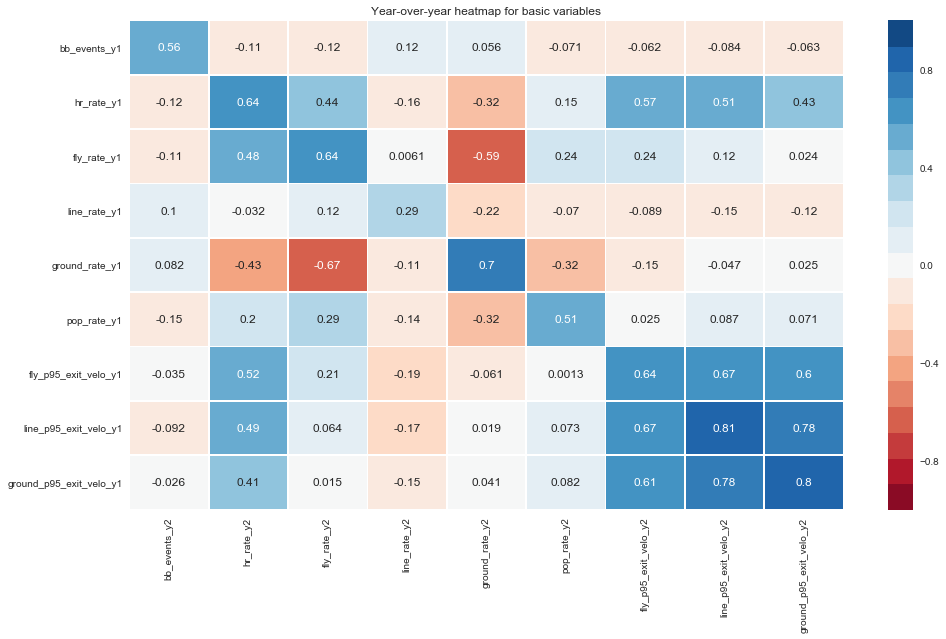

In [198]:
basic_vars_y1 = [
    'bb_events_y1',
    'hr_rate_y1',
    'fly_rate_y1',
    'line_rate_y1',
    'ground_rate_y1',
    'pop_rate_y1',
    'fly_p95_exit_velo_y1',
    'line_p95_exit_velo_y1',
    'ground_p95_exit_velo_y1'
]
basic_vars_y2 = [
    'bb_events_y2',
    'hr_rate_y2',
    'fly_rate_y2',
    'line_rate_y2',
    'ground_rate_y2',
    'pop_rate_y2',
    'fly_p95_exit_velo_y2',
    'line_p95_exit_velo_y2',
    'ground_p95_exit_velo_y2'
]

plot_yoy(df_yoy, basic_vars_y1, basic_vars_y2, 'basic')

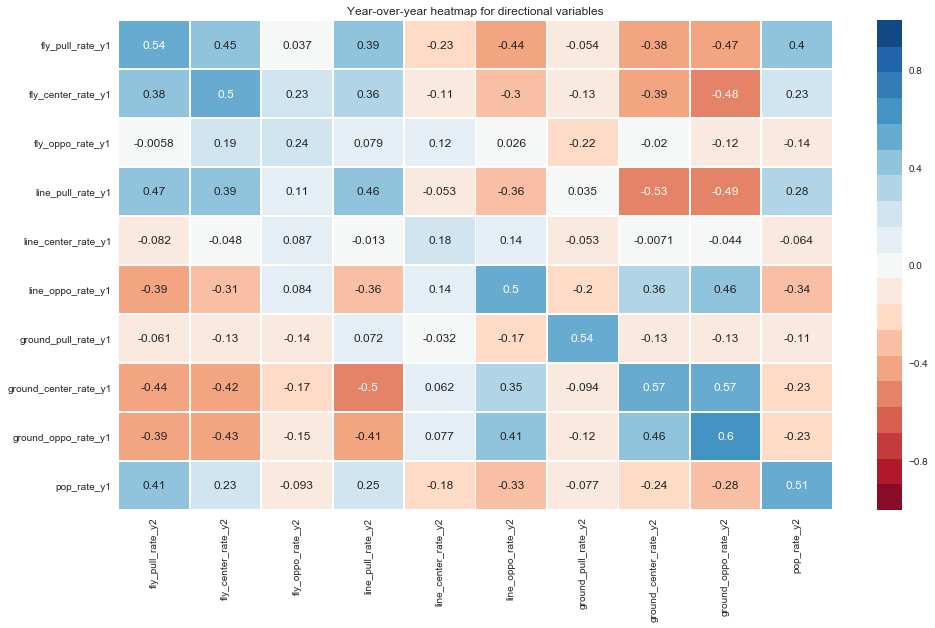

In [199]:
dir_vars_y1 = [
    'fly_pull_rate_y1',
    'fly_center_rate_y1',
    'fly_oppo_rate_y1',
    'line_pull_rate_y1',
    'line_center_rate_y1',
    'line_oppo_rate_y1',
    'ground_pull_rate_y1',
    'ground_center_rate_y1',
    'ground_oppo_rate_y1',
    'pop_rate_y1'
]
dir_vars_y2 = [
    'fly_pull_rate_y2',
    'fly_center_rate_y2',
    'fly_oppo_rate_y2',
    'line_pull_rate_y2',
    'line_center_rate_y2',
    'line_oppo_rate_y2',
    'ground_pull_rate_y2',
    'ground_center_rate_y2',
    'ground_oppo_rate_y2',
    'pop_rate_y2'
]

plot_yoy(df_yoy, dir_vars_y1, dir_vars_y2, 'directional')

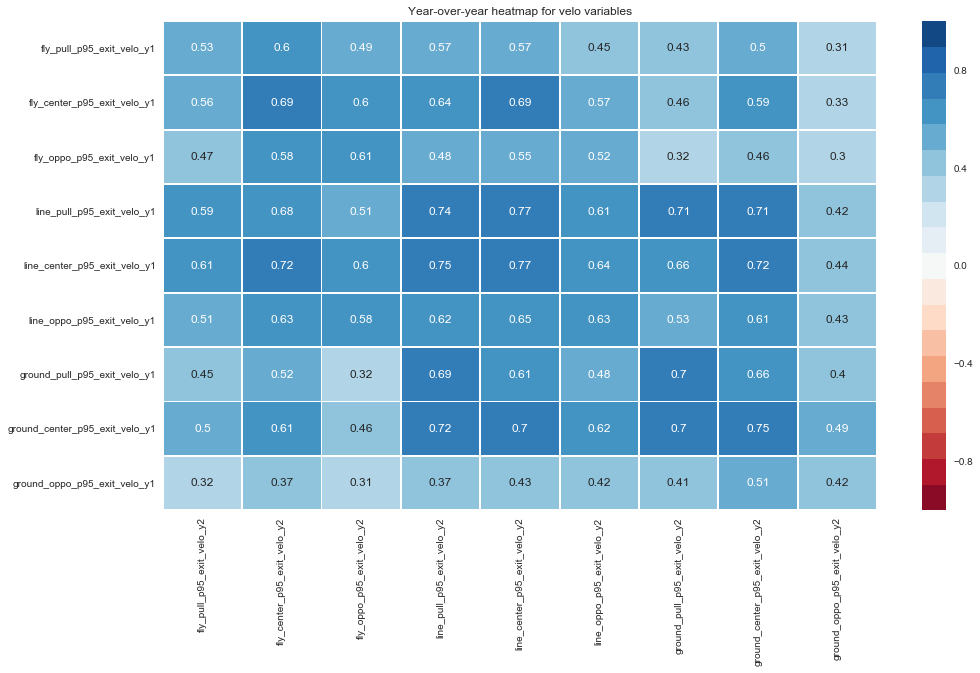

In [200]:
velo_vars_y1 = [
    'fly_pull_p95_exit_velo_y1',
    'fly_center_p95_exit_velo_y1',
    'fly_oppo_p95_exit_velo_y1',
    'line_pull_p95_exit_velo_y1',
    'line_center_p95_exit_velo_y1',
    'line_oppo_p95_exit_velo_y1',
    'ground_pull_p95_exit_velo_y1',
    'ground_center_p95_exit_velo_y1',
    'ground_oppo_p95_exit_velo_y1'
]
velo_vars_y2 = [
    'fly_pull_p95_exit_velo_y2',
    'fly_center_p95_exit_velo_y2',
    'fly_oppo_p95_exit_velo_y2',
    'line_pull_p95_exit_velo_y2',
    'line_center_p95_exit_velo_y2',
    'line_oppo_p95_exit_velo_y2',
    'ground_pull_p95_exit_velo_y2',
    'ground_center_p95_exit_velo_y2',
    'ground_oppo_p95_exit_velo_y2'
]

plot_yoy(df_yoy, velo_vars_y1, velo_vars_y2, 'velo')

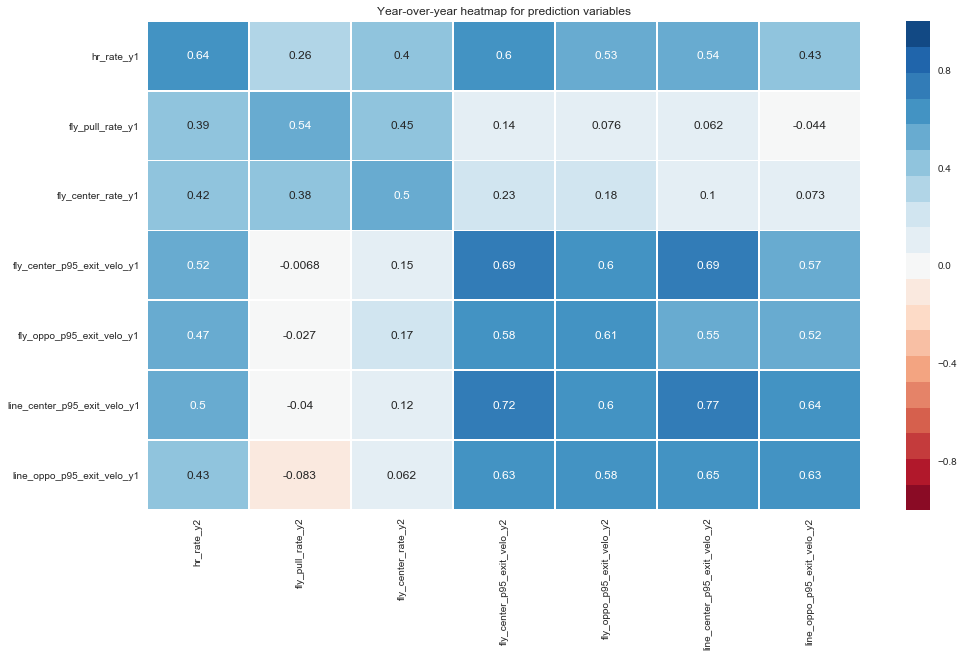

In [201]:
pred_vars_y1 = [
    'hr_rate_y1',
    'fly_pull_rate_y1',
    'fly_center_rate_y1',
    'fly_center_p95_exit_velo_y1',
    'fly_oppo_p95_exit_velo_y1',
    'line_center_p95_exit_velo_y1',
    'line_oppo_p95_exit_velo_y1'
]
pred_vars_y2 = [
    'hr_rate_y2',
    'fly_pull_rate_y2',
    'fly_center_rate_y2',
    'fly_center_p95_exit_velo_y2',
    'fly_oppo_p95_exit_velo_y2',
    'line_center_p95_exit_velo_y2',
    'line_oppo_p95_exit_velo_y2'
]

plot_yoy(df_yoy, pred_vars_y1, pred_vars_y2, 'prediction')

## Distributions

In [202]:
def plot_distributions(data, features, label, kind='kde'):
    assert kind in ['kde', 'violin', 'box'], '`kind` must be one of \'kde\', \'violin\' or \'box\''
    
    if kind == 'kde':
        for feature in features:
            _df = data[feature]

            sns.kdeplot(data=data[feature], label=feature, shade=True)

    elif kind == 'violin':
        _df = data[features]

        sns.violinplot(data=_df, orient='h')

    elif kind == 'box':
        _df = data[features]

        sns.boxplot(data=_df, orient='h')
        
    plt.title('Distribution of {}'.format(label))
    plt.show()

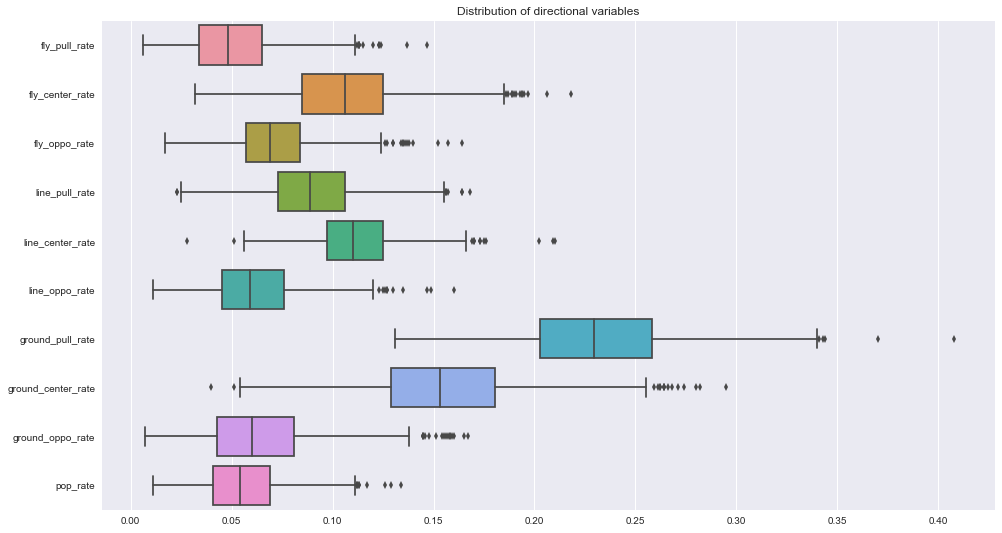

In [203]:
dir_vars = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_pull_rate',
    'ground_center_rate',
    'ground_oppo_rate',
    'pop_rate'
]

plot_distributions(df_threshold, dir_vars, 'directional variables', kind='box')

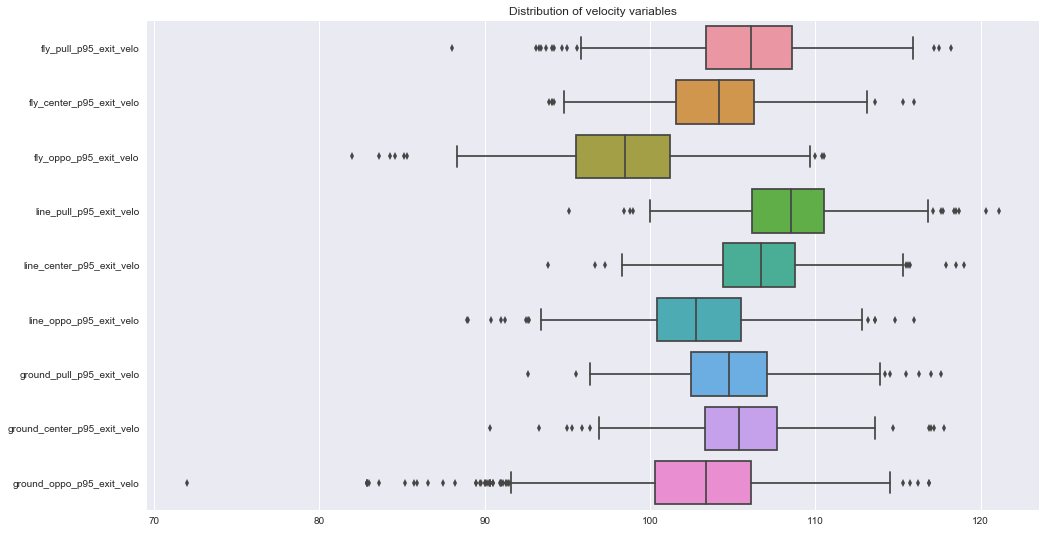

In [205]:
velo_vars = [
    'fly_pull_p95_exit_velo',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_pull_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo',
    'ground_pull_p95_exit_velo',
    'ground_center_p95_exit_velo',
    'ground_oppo_p95_exit_velo'
]

plot_distributions(df_threshold, velo_vars, 'velocity variables', kind='box')